In [185]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.datasets import load_digits
from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import PCA

# Section 2
Original notes [here](https://princeton-introml.github.io/)

In [268]:
# Load MNIST Dataset
k = 2 # Feel free to change this!
X_, _ = load_digits(n_class=k, return_X_y=True)

In [256]:
# Data Visualization:
# - So far, we've loaded images corresponding to two digits: 0 and 1!
# - Within X, each row is a flat vector of size 64 corrersponding to an 8x8 image
# - To get a sense of the image data, the following 3 lines should create a picture of a tiny 0!
X[0].reshape((8,8))
img = Image.fromarray(np.uint8(X[0].reshape((8,8))*16), 'L')
img.show()

In [269]:
# Prepare Data
X = scale(X_) # Normalize data
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):] # 20% Test

In [270]:
# Define functions    
def initialize_cluster_mean(X, k):
    # X: array of shape (n, d), each row is a d-dimensional data point
    # k: number of clusters
    # returns Y: array of shape (k, d), each row is the center of a cluster
    
    # -- k-means++ Initialization --
    
    # Pick random initial center
    init_idx = np.random.choice(len(X))
    Y = [X[init_idx]]
    
    # Repeat this step k times
    for _ in range(k-1):
        # Array of distances(point, center)
        weights = []
        
        # For each point...
        for x in X:
            # Distance to nearest center
            nearest = min([np.linalg.norm(x - center) for center in Y])
            weights.append(nearest**2)
        
        # Pick random center w/ prob. weighted by distances^2
        weights = np.array(weights)
        weights = normalize(
            weights[:,np.newaxis],
            axis=0,
            norm='l1'
        ).ravel()
        idx = np.random.choice(len(X), size=1, p=weights)
        Y.append(X[idx])
    
    assert len(Y) == k
    return Y

def assign_cluster(X, Y):
    # X: array of shape (n, d), each row is a d-dimensional data point
    # Y: array of shape (k, d), each row is the center of a cluster
    # returns loss, the sum of squared distance from each point to its assigned cluster
    # returns C: array of shape (n), each value is the index of the closest cluster
    
    loss, C = 0, []
    
    for x in X:
        # Find nearest center to point
        distance, nearest_center_idx = float('inf'), -1
        for idx in range(len(Y)):
            center = Y[idx]
            if distance > np.linalg.norm(x - center):
                distance = np.linalg.norm(x - center)
                nearest_center_idx = idx
        
        # Loss = Sum(distance(point to cluster)^2)
        loss += distance**2
        # Append index of closest center to C
        C.append(nearest_center_idx)
        
    return loss, np.array(C)

def update_cluster_mean(X, k, C):
    # X: array of shape (n, d), each row is a d-dimensional data point
    # k: number of clusters
    # C: array of shape (n), each value is the index of the closest cluster
    # returns Y: array of shape (k, d), each row is the center of a cluster
    
    Y = np.array([np.zeros(X.shape[1]) for _ in range(k)])
    
    # Calculate new centroid = mean of updated clusters
    for x, c in list(zip(X, C)):
        Y[c] += x
    for idx in range(len(Y)):
        Y[idx] = Y[idx] / len(y)
    return Y

In [279]:
def k_means(X, k, max_iters=50, eps=1e-5):
    Y = initialize_cluster_mean(X, k)
    
    loss, losses = -1, []
    for i in range(max_iters):
        # Assign points to new clusters according to 
        loss, C = assign_cluster(X, Y)
        Y = update_cluster_mean(X, k, C)
        
        # Calculate change in loss (conditional captures initial iteration)
        loss_change = np.abs(loss - losses[-1]) if len(losses) > 0 else eps + 1
        losses.append(loss)
        if loss_change < eps:
            break
    
    return loss, C, Y, losses

def scatter_plot(X, C):
    plt.figure(figsize=(12, 10))
    
    k = int(C.max()) + 1
    from itertools import cycle
    colors = cycle('bgrcmk')
    
    for i in range(k):
        idx = (C == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=next(colors))
    plt.title("Scatter Plot of Clusters")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

Losses: [17091.109657429915, 12651.174015486624, 12651.174015486624]


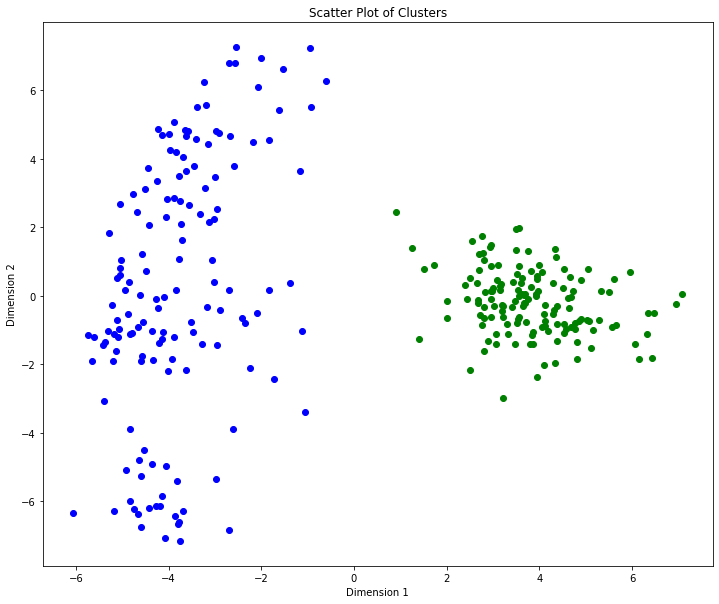

In [280]:
# Run k-means algorithm and plot the result
loss, C, Y, losses = k_means(X_train, k)
print("Losses:", losses)

# Create a 2D plot with axes as 2 most distinguishing features of 64 dims of X_train data
low_dim = PCA(n_components=2).fit_transform(X_train)
scatter_plot(low_dim, C)